In [13]:
# Churn Prediction using Logistic Regression (Phase 1–5)
# ------------------------------------------------------

# 📦 Phase 1: Imports and Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings("ignore")

In [14]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn 2.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
# 📊 Phase 2

# Clean 'TotalCharges' column (contains empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Drop irrelevant ID column
df.drop(['customerID'], axis=1, inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [16]:
# 🧹 Phase 3: Preprocessing

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Split features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Balance the training set using SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Scale numeric features
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

In [17]:
# 🤖 Phase 4: Logistic Regression Modeling

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bal_scaled, y_train_bal)

# Predictions and probabilities
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"AUC Score: {auc:.3f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

AUC Score: 0.826

Confusion Matrix:
 [[845 188]
 [129 245]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1033
           1       0.57      0.66      0.61       374

    accuracy                           0.77      1407
   macro avg       0.72      0.74      0.72      1407
weighted avg       0.79      0.77      0.78      1407



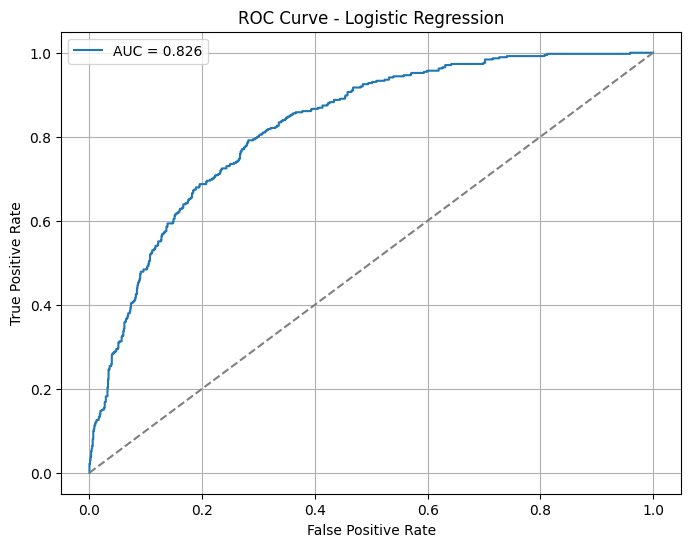

In [18]:
# 📌 Optional: Visualize ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

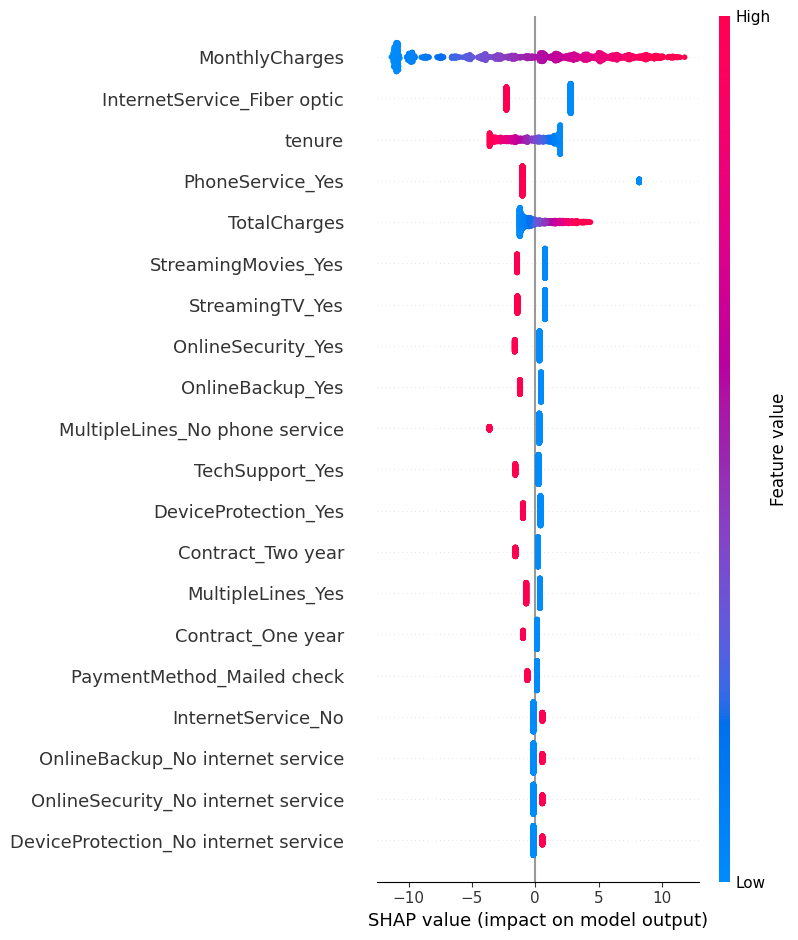

In [19]:
# 🔍 Phase 5: SHAP Explainability

# SHAP requires full feature names; use original X_train
explainer = shap.Explainer(lr, X_train_bal_scaled)
shap_values = explainer(X_test_scaled)

# Global Feature Importance (Bar)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=True)

<Axes: xlabel='Contract', ylabel='Churn'>

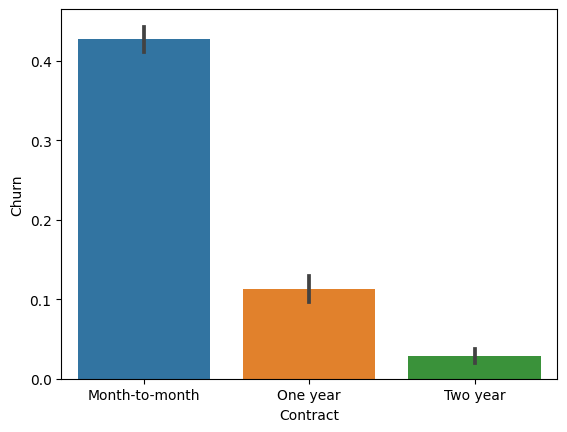

In [20]:
sns.barplot(x='Contract', y='Churn', data=df.replace({'Yes': 1, 'No': 0}))

<Axes: >

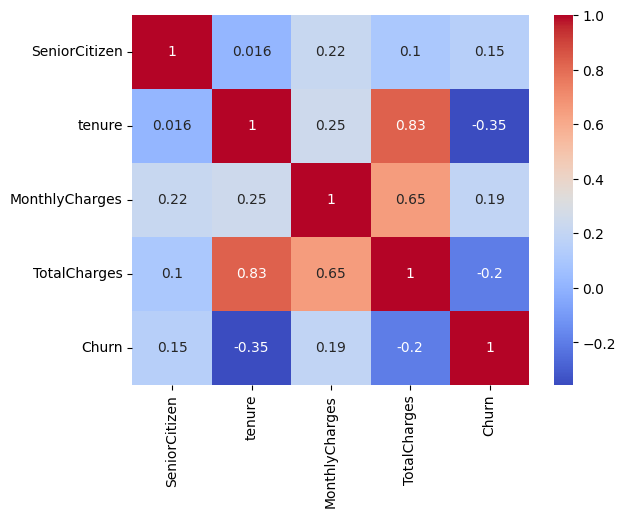

In [21]:
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=True)

In [27]:
df_with_preds = X_test.copy()
df_with_preds['Churn_Prob'] = y_proba
df_with_preds['Churn_Pred'] = y_pred
df_with_preds['Actual_Churn'] = y_test.values

df_with_preds.to_csv('churn_with_predictions.csv', index=False)